In [1]:
import sys
import os
import json
from shapely.geometry import shape
import numpy as np
from dask.distributed import Client, LocalCluster
from pystac_client import Client as StacClient
import stackstac
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
cluster = LocalCluster(
    n_workers=3,             # safe for 15 GB RAM
    threads_per_worker=1,    # raster operations run best single-threaded
    memory_limit="4GB"       # 3 workers × 4GB = 12GB used
)

client = Client(cluster)
cluster


LocalCluster(cd12e125, 'tcp://127.0.0.1:34877', workers=3, threads=3, memory=11.18 GiB)

In [3]:
os.getcwd()

'/home/jupyteruser/scr/notebooks'

In [3]:
# Add the folder containing WQI_utils.py
sys.path.append(os.path.abspath("../utils"))

## 2 Import the main functions
from wqi_utils import wqi
from plots_utils import plot_time_series, plot_seasonal_cycle
from wrapper_plots_utils import workflow_analysis

Found 100 Sentinel-2 scenes.


/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stack mosaic shape: (56, 5, 9969, 24335)


2025-12-03 17:04:38,413 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.98 GiB -- Worker memory limit: 3.73 GiB
2025-12-03 17:04:38,570 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 2.18 GiB -- Worker memory limit: 3.73 GiB
2025-12-03 17:07:21,118 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.99 GiB -- Worker memory limit: 3.73 GiB
2025-12-03 17:07:21,224 - distributed.worker.memory - WARNING - Worker is at 59% memory usage. Resuming worker. Process memory: 2.23 GiB -- Worker memory limit: 3.73 GiB
2025-12-03 17:07:37,628 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 3.12 GiB -- Worker memory limit: 3.73 GiB
2025-12-03 17:07:37,726 - distributed.worker.memory - WARNING - Worker is at 44% memory usage. Resuming worker. Process memory: 1.67 GiB -- Worker mem

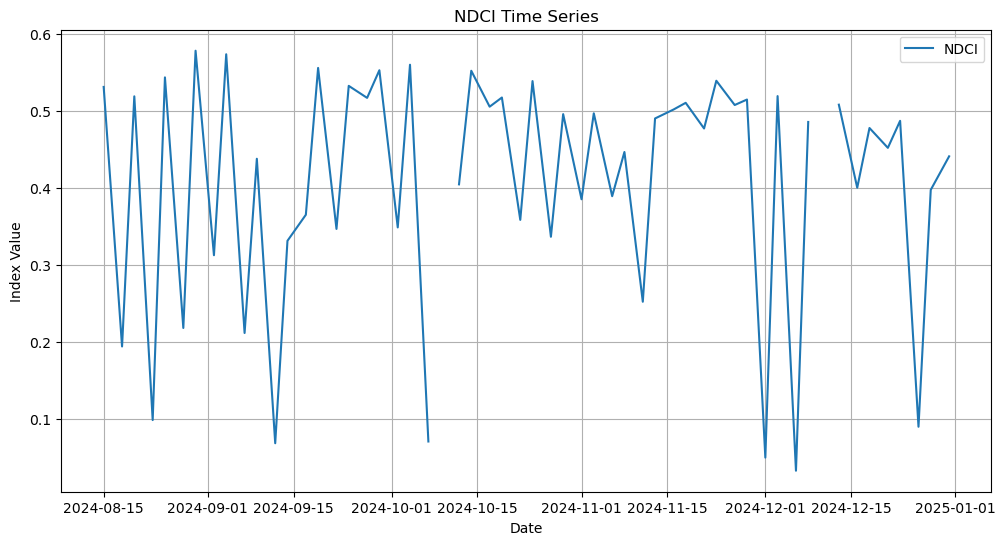

In [6]:
result = wqi(
    bbox=bbox,
    start_date="2019-01-01",
    end_date="2024-12-31",
    max_items=100
)

ndwi_ts = result["indices"]["NDWI"]["time_series"]
ndti_ts = result["indices"]["NDTI"]["time_series"]
ndci_ts = result["indices"]["NDCI"]["time_series"]

plt.figure(figsize=(12, 6))
plt.plot(ndci_ts.time.values, ndci_ts.values, label="NDCI")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("NDCI Time Series")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
bbox = [-82.8, 27.5, -82.2, 28.2]

result = wqi(
    bbox=bbox,
    start_date="2019-01-01",
    end_date="2024-12-31",
    max_items = 100
)

ndwi = result["indices"]["NDWI"]
ndti = result["indices"]["NDTI"]
ndci = result["indices"]["NDCI"]

Found 100 Sentinel-2 scenes.


/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stack mosaic shape: (56, 5, 9969, 24335)


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ndci.time.values, ndci.values, label="NDCI", color="blue")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("NDCI Time Series")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'dict' object has no attribute 'time'

<Figure size 1200x600 with 0 Axes>

In [5]:
result['stack']


<xarray.DataArray 'stackstac-8ad2b4e1d9f633d980c564d9de872fac' (time: 56,
                                                                band: 5,
                                                                y: 9969,
                                                                x: 24335)> Size: 543GB
dask.array<stack, shape=(56, 5, 9969, 24335), dtype=float64, chunksize=(1, 1, 9969, 1682), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                                     (time) datetime64[ns] 448B 2024-...
  * band                                     (band) <U8 160B 'green' ... 'red...
  * y                                        (y) float64 80kB 3.144e+06 ... 3...
  * x                                        (x) float64 195kB -2.718e+05 ......
    processing:software                      object 8B {'sentinel2-to-stac': ...
    earthsearch:boa_offset_applied           bool 1B True
    ...                                       ...
    gsd                                      (band) object 40B 10 10 10 None 20
    raster:bands                             (band) object 40B {'nodata': 0, ...
    common_name                              (band) object 40B 'green' ... 'r...
    center_wavelength                        (band) object 40B 0.56 ... 0.783
    full_width_half_max                      (band) object 40B 0.045 ... 0.028
    epsg                                     int64 8B 32618
Attributes:
    spec:           RasterSpec(epsg=32618, bounds=(-271801.56728576886, 30625...
    crs:            epsg:32618
    transform:      | 2.64, 0.00,-271801.57|\n| 0.00,-8.18, 3144121.51|\n| 0....
    resolution_xy:  (2.63631623280312, 8.182744828553213)

In [6]:
print(ndci)
print(ndwi)
print(ndti)


{'spatial': <xarray.DataArray 'stackstac-8ad2b4e1d9f633d980c564d9de872fac' (time: 56,
                                                                y: 9969,
                                                                x: 24335)> Size: 109GB
dask.array<where, shape=(56, 9969, 24335), dtype=float64, chunksize=(1, 9969, 1682), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                                     (time) datetime64[ns] 448B 2024-...
  * y                                        (y) float64 80kB 3.144e+06 ... 3...
  * x                                        (x) float64 195kB -2.718e+05 ......
    processing:software                      object 8B {'sentinel2-to-stac': ...
    earthsearch:boa_offset_applied           bool 1B True
    constellation                            <U10 40B 'sentinel-2'
    ...                                       ...
    title                                    <U30 120B 'Scene classification ...
    gsd                                    

In [10]:
# Extract individual DataArrays from the dictionary
ndci = indices['NDCI']
ndwi = indices['NDWI']
ndti = indices['NDTI']

# Plot NDCI as an example
plt.figure(figsize=(12, 6))
plt.plot(ndci.time, ndci.values, label="NDCI", color="blue")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.title("NDCI Time Series")
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'dict' object has no attribute 'time'

<Figure size 1200x600 with 0 Axes>

In [9]:
plt.figure(figsize=(12,6))
plot_time_series(ndci, "NDCI")

plt.figure(figsize=(12,6))
plot_seasonal_cycle(ndci, "NDCI")

2025-12-01 20:30:30,352 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('fetch_raster_window-getitem-290f66be35d2eee98796b1f2b64cc9d5', 50, 0, 4))" coro=<Worker.execute() done, defined at /opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/distributed/worker_state_machine.py:3609>> ended with CancelledError
2025-12-01 20:30:30,353 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('fetch_raster_window-getitem-290f66be35d2eee98796b1f2b64cc9d5', 50, 0, 7))" coro=<Worker.execute() done, defined at /opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/distributed/worker_state_machine.py:3609>> ended with CancelledError
2025-12-01 20:30:30,353 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('fetch_raster_window-getitem-ca9a07241f3a4a0afb446bb2b9b85d32', 50, 0, 10))" coro=<Worker.execute() done, defined at /opt/co

KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

2025-12-01 20:30:32,937 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/opt/conda/envs/geog313-final-project/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/geog313-final-project/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/distributed/nanny.py", line 984, in run
    await worker.finished()
  File "/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/distributed/core.py", line 491, in finished
    await self._event_finished.wait()
  File "/opt/conda/envs/geog313-final-project/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the a

In [ ]:
# Compute NDCI series
ndci_series = result["indices"]["NDCI"].compute()  # get actual values
time = result["indices"]["NDCI"].time.values      # get time coordinates

plt.figure(figsize=(10,5))
plt.plot(time, ndci_series, marker="o", linestyle="--", color="green")
plt.title("NDCI Time Series")
plt.xlabel("Time")
plt.ylabel("Mean NDCI")
plt.grid(True)
plt.show()


In [ ]:
wqi_time_series(
    bbox=bbox,
    start_date=START_DATE,
    end_date=END_DATE,
    filter_clouds=True,          
)

In [ ]:
main(
    bbox=bbox,
    start_date=START_DATE,
    end_date=END_DATE,
    filter_clouds=False,
)

In [ ]:
from pystac_client import Client

client = Client.open("https://earth-search.aws.element84.com/v1")
items = client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=f"{START_DATE}/{END_DATE}",
    max_items=500
).item_collection()

print("Number of items found:", len(items))


In [ ]:
wqi_dict = wqi(
    bbox=bbox,
    start_date=START_DATE,
    end_date=END_DATE,
    filter_clouds=True,          
)